# 1. Hyperparameter optimization

To install Optuna: run `pip install optuna` in console after activating your environment.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math
import optuna
import optuna.visualization as vis

seed = 42
torch.manual_seed(seed)

Load MNIST data. **DO NOT CHANGE THIS.**

In [2]:
def get_mnist_loaders(batch_size, valid_ratio, seed, downsample_ratio):
    # Define the transformation: convert to tensor and normalize
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    # Load the full training set (train=True returns the 60k training images)
    train_dataset = torchvision.datasets.MNIST(
        root="data",
        train=True,
        download=True,
        transform=transform
    )
    
    # Optionally downsample the training data
    if downsample_ratio < 1.0:
        subset_size = int(len(train_dataset) * downsample_ratio)
        indices = list(range(subset_size))
        train_dataset = Subset(train_dataset, indices)
    
    # Load the test set (train=False returns the 10k testing images)
    test_dataset = torchvision.datasets.MNIST(
        root="data",
        train=False,
        download=True,
        transform=transform
    )
    
    # Split training set into training and validation set
    train_size = int((1.0 - valid_ratio) * len(train_dataset))
    valid_size = len(train_dataset) - train_size
    gen = torch.Generator().manual_seed(seed)
    train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size], generator=gen)
    
    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)
    
    return train_loader, valid_loader, test_loader

batch_size = 128
valid_ratio = 0.2
downsample_ratio = 0.5

# Create the DataLoaders
train_loader, valid_loader, test_loader = get_mnist_loaders(batch_size=batch_size, 
                                                              valid_ratio=valid_ratio, 
                                                              seed=seed,
                                                              downsample_ratio=downsample_ratio)

# Total number of images in each dataset
print("Total training images:", len(train_loader.dataset))
print("Total validation images:", len(valid_loader.dataset))
print("Total test images:", len(test_loader.dataset))

Total training images: 24000
Total validation images: 6000
Total test images: 10000


## (1a) Implement CNN

Write here the network structure as described in the exercise sheet.

Remember to **make the kernel size a parameter**, so that it can be controlled later.

In [3]:
class CNN(nn.Module):
    
    def __init__(self, kernel_size):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=kernel_size, stride=1)
        self.temp = math.floor((27 - kernel_size) / 2 + 1)
        self.fc1 = nn.Linear(self.temp * self.temp * 16, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, self.temp * self.temp * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

#### (1b & 1c) Train&Test Functions

To help focus on tuning optimizers and networks, we provided 3 pre-written functions for training and testing.

By having clear functions, we can easily compare different settings and keep the process consistent.

**You do not need to change anything in this part.**

In [4]:
# Training function.
def train(net, train_loader, parameters, epochs=1):
    optimizer = torch.optim.SGD(net.parameters(), lr=parameters["lr"], momentum=parameters["momentum"])
    criterion = nn.NLLLoss()
    net.train()
    for epoch in range(epochs):
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return net

# Evaluation function.
def evaluate(net, data_loader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            outputs = net(images)
            predictions = outputs.argmax(dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    return accuracy

# Function for final training using best params on combined train and validation sets, then testing.
def train_test(parameters):
    combined_dataset = ConcatDataset([train_loader.dataset, valid_loader.dataset])
    combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)
    
    net = CNN(kernel_size=parameters["kernel_size"])
    net = train(net, combined_loader, parameters)
    test_accuracy = evaluate(net, test_loader)
    return test_accuracy

## (1b) Bayesian optimization using Optuna

Optuna requires an objective for the optimization.

Our objective returns validation accuracy, and we use direction="maximize".

So, we aim to maximize the accuracy of the validation dataset.

**Here, your task is to define the hyperparameter search spaces** (suggested hyperparameters).

Here you can see the documentary page for search spaces:

https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html

In [5]:
def objective(trial):
    # Define hyperparameter search spaces.
    lr = trial.suggest_float("lr", 1e-6, 1e-2, log=True)
    momentum = trial.suggest_float("momentum", 0.0, 1.0)
    kernel_size = trial.suggest_categorical("kernel_size", [3, 5, 7])
    parameters = {"lr": lr, "momentum": momentum, "kernel_size": kernel_size}
    
    # Initialize the model with the chosen kernel_size.
    net = CNN(kernel_size=kernel_size)
    
    # Train the model on the training set.
    net = train(net, train_loader, parameters)
    
    # Evaluate validation sets.
    val_accuracy = evaluate(net, valid_loader)
    
    # Return the validation accuracy (this is what we want to maximize).
    return val_accuracy

# Create Optuna study and optimize.
n_trials = 75
sampler = optuna.samplers.TPESampler(seed=seed)
study = optuna.create_study(sampler=sampler, direction="maximize")
study.optimize(objective, n_trials=n_trials)

print("Best hyperparameters:", study.best_trial.params)
print("Best validation accuracy:", study.best_trial.value)

[I 2025-04-11 16:14:40,599] A new study created in memory with name: no-name-d980600b-6d38-4bfa-8d20-6fce64b869c7
[I 2025-04-11 16:14:43,987] Trial 0 finished with value: 0.25066666666666665 and parameters: {'lr': 3.1489116479568635e-05, 'momentum': 0.9507143064099162, 'kernel_size': 3}. Best is trial 0 with value: 0.25066666666666665.
[I 2025-04-11 16:14:47,366] Trial 1 finished with value: 0.091 and parameters: {'lr': 4.207053950287936e-06, 'momentum': 0.05808361216819946, 'kernel_size': 3}. Best is trial 0 with value: 0.25066666666666665.
[I 2025-04-11 16:14:50,721] Trial 2 finished with value: 0.09633333333333334 and parameters: {'lr': 1.2087541473056965e-06, 'momentum': 0.9699098521619943, 'kernel_size': 3}. Best is trial 0 with value: 0.25066666666666665.
[I 2025-04-11 16:14:54,088] Trial 3 finished with value: 0.1295 and parameters: {'lr': 5.415244119402541e-06, 'momentum': 0.3042422429595377, 'kernel_size': 3}. Best is trial 0 with value: 0.25066666666666665.
[I 2025-04-11 16:1

Best hyperparameters: {'lr': 0.00983387984728913, 'momentum': 0.9093386968088377, 'kernel_size': 7}
Best validation accuracy: 0.9508333333333333


C:\Users\arasu\AppData\Local\Temp\ipykernel_26984\2604171193.py:6: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig_history = optuna.visualization.matplotlib.plot_optimization_history(study)


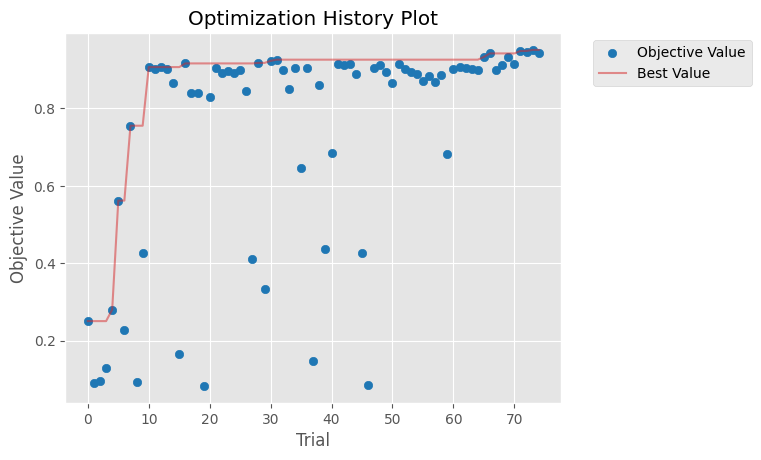

In [6]:
# Visualize the optimization history. (Interactive)
#fig_history = vis.plot_optimization_history(study)
#fig_history.show()

# Alternative Visualization. You can use this if the plot is not visible in .pdf version (Matplotlib plot)
fig_history = optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

In [7]:
# Evaluate on the test set using the best hyperparameters.
test_accuracy = train_test(study.best_trial.params)
print("Test accuracy with best hyperparameters:", test_accuracy)

Test accuracy with best hyperparameters: 0.9589


## (1c) Grid search

Implement grid search for the same three parameters.

Remember that you **need to cover 75 alternatives in total.**

So, think about how to best allocate those to cover the three hyperparameters.

In [8]:
values = {}

# Loop over 5 values for learning rate, 5 momentum values, and 3 kernel sizes.
# This gives 5 * 5 * 3 = 75 alternatives.
for lr in np.geomspace(1e-6, 1e-2, 5):
    for momentum in [0.0, 0.5, 0.9, 0.95, 0.99]:
        for kernel_size in [3, 5, 7]:
            parameterization = {"lr": lr, "momentum": momentum, "kernel_size": kernel_size}
            net = CNN(kernel_size=kernel_size)
            net = train(net, train_loader, parameterization)
            val_accuracy = evaluate(net, valid_loader)
            values[str(parameterization)] = val_accuracy
            
            print({"lr": float(lr), "momentum": momentum, "kernel_size": kernel_size}, 
                  ", Validation Accuracy:", val_accuracy)

# Get best parameterization (highest val accuracy)
best_key = max(values, key=values.get)
best_params = eval(best_key)
print("\nBest hyperparameters (grid search):", best_params, 
      "with validation accuracy:", values[best_key])

{'lr': 1e-06, 'momentum': 0.0, 'kernel_size': 3} , Validation Accuracy: 0.10233333333333333
{'lr': 1e-06, 'momentum': 0.0, 'kernel_size': 5} , Validation Accuracy: 0.109
{'lr': 1e-06, 'momentum': 0.0, 'kernel_size': 7} , Validation Accuracy: 0.113
{'lr': 1e-06, 'momentum': 0.5, 'kernel_size': 3} , Validation Accuracy: 0.1145
{'lr': 1e-06, 'momentum': 0.5, 'kernel_size': 5} , Validation Accuracy: 0.09966666666666667
{'lr': 1e-06, 'momentum': 0.5, 'kernel_size': 7} , Validation Accuracy: 0.117
{'lr': 1e-06, 'momentum': 0.9, 'kernel_size': 3} , Validation Accuracy: 0.08516666666666667
{'lr': 1e-06, 'momentum': 0.9, 'kernel_size': 5} , Validation Accuracy: 0.11316666666666667
{'lr': 1e-06, 'momentum': 0.9, 'kernel_size': 7} , Validation Accuracy: 0.096
{'lr': 1e-06, 'momentum': 0.95, 'kernel_size': 3} , Validation Accuracy: 0.1045
{'lr': 1e-06, 'momentum': 0.95, 'kernel_size': 5} , Validation Accuracy: 0.14983333333333335
{'lr': 1e-06, 'momentum': 0.95, 'kernel_size': 7} , Validation Accur

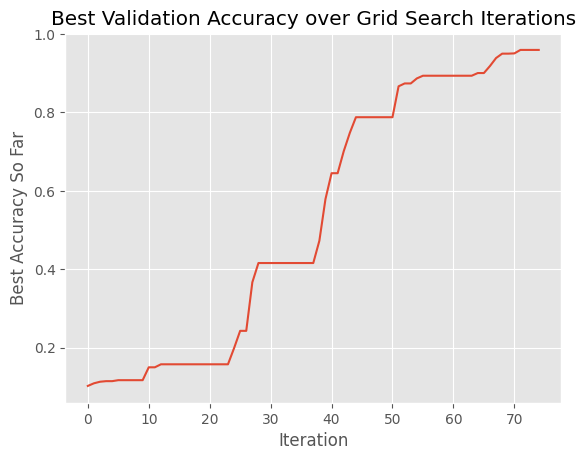

In [9]:
# Track the best validation accuracy so far for each iteration.
bests = []
best_so_far = 0.0
for key, value in values.items():
    if value > best_so_far:
        best_so_far = value
    bests.append(best_so_far)

# Plot the best validation accuracy observed over the iterations.
plt.plot(bests)
plt.title("Best Validation Accuracy over Grid Search Iterations")
plt.xlabel("Iteration")
plt.ylabel("Best Accuracy So Far")
plt.show()

In [10]:
final_test_accuracy = train_test(best_params)
print("\nFinal Test Accuracy with best hyperparameters from grid search:", final_test_accuracy)


Final Test Accuracy with best hyperparameters from grid search: 0.9661


## Observations

- Both BO and grid search reached similar final test accuracies. BO achieved a test accuracy of about 95.89% and grid search reached 96.61%. 

- However, BO found near optimal hyperparameters after only about 10 trials. In grid search, the order of evaluation is fixed, so hitting a good parameter is just a matter of luck. If a promising combination is evaluated early, you see good performance quickly. If not, you might have to wait until the end.

- When setting the search range for parameters like the learning rate, using a linear spacing is not ideal. For instance, a linear range between $1e-5$ and $1.0$ with 6 values would give $1e-5$, $0.2$, $0.4$, $0.6$, $0.8$, $1.0$, meaning most values are near the largest value. A geometric spacing like $1e-5$, $1e-4$, $1e-3$, $1e-2$, $1e-1$, $1e0$ gives a more balanced and effective exploration. So for grid search, exact values need to be specified carefully, as it is a choice where mistakes can easily happen.


# 2. Transfer learning

In [11]:
import random

seed = 42
torch.manual_seed(seed)
random.seed(seed)

Model - **DO NOT CHANGE THIS**

In [12]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Block 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(16)
        self.MaxPool1 = nn.MaxPool2d(kernel_size=2)

        # Block 2
        self.cnn2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(32)
        self.MaxPool2 = nn.MaxPool2d(kernel_size=2)

        # Block 3
        self.cnn3 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(64)
        self.MaxPool3 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(576, 10)  # Fully connected layer

    def forward(self, x):
        out = self.MaxPool1(self.bn1(self.relu1(self.cnn1(x))))
        out = self.MaxPool2(self.bn2(self.relu2(self.cnn2(out))))
        out = self.MaxPool3(self.bn3(self.relu3(self.cnn3(out))))

        out = out.view(out.size(0), -1)
        out = self.fc1(out)

        return out

Load Fashion-MNIST data. 128 training samples, 10k test samples. **DO NOT CHANGE THIS**

In [13]:
transform = transforms.Compose([transforms.ToTensor()])
        
# Load full dataset
full_train_dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

batch_size = 128

# Slice small set of data
indices = random.sample(range(len(full_train_dataset)), batch_size)
train_dataset = Subset(full_train_dataset, indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Training set size:", len(train_loader.dataset))
print("Test set size:", len(test_loader.dataset))

Training set size: 128
Test set size: 10000


We recommend writing a general training function that implements all three alternative models.

Below **train_model()** function is a template that already has some functionality for storing the errors, doing evaluation over test dataset and printing results.

You should think about how to implement alternative ways of doing transfer learning.

Once you have this function, you can simply run the following cells to try out the alternative approaches.

In [14]:
# Training function
def train_model(model, train_loader, test_loader, optimizer, criterion, epochs, freeze_layers):
    if freeze_layers:
        # Freeze all layers except fc1
        for name, param in model.named_parameters():
            if name not in ['fc1.weight', 'fc1.bias']:
                param.requires_grad = False

    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    
    # Training Loop
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        train_losses.append(total_loss / total)
        train_accs.append(100 * correct / total)

        # Evaluation
        model.eval()
        test_loss_total, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss_total += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        test_losses.append(test_loss_total / total)
        test_accs.append(100 * correct / total)

        print(f"Epoch {epoch+1:>2}/{epochs} | "
              f"Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accs[-1]:.2f}% | "
              f"Test Loss: {test_losses[-1]:.4f} | Test Acc: {test_accs[-1]:.2f}%")

    return train_losses, test_losses, train_accs, test_accs

## (2a) From Scratch

Create a new CNNModel and train from scratch.

- Here, we train the CNN model from scratch by initializing it with random weights using `model1 = CNNModel()` and setting `freeze_layers` to `False`, meaning all layers are updated during training. The `train_model()` function is written in a way that it can be used in all three alternatives by giving required inputs.

In [15]:
model1 = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01)
epochs = 70
freeze_layers = False
train_loss1, test_loss1, train_acc1, test_acc1 = train_model(model1, train_loader, test_loader, optimizer1,
                                                             criterion, epochs=epochs, freeze_layers=freeze_layers)

Epoch  1/70 | Train Loss: 2.5355 | Train Acc: 10.16% | Test Loss: 2.3114 | Test Acc: 18.27%
Epoch  2/70 | Train Loss: 2.2945 | Train Acc: 59.38% | Test Loss: 2.1899 | Test Acc: 17.21%
Epoch  3/70 | Train Loss: 1.7182 | Train Acc: 48.44% | Test Loss: 2.0385 | Test Acc: 28.75%
Epoch  4/70 | Train Loss: 1.0557 | Train Acc: 71.09% | Test Loss: 2.0840 | Test Acc: 29.94%
Epoch  5/70 | Train Loss: 0.6350 | Train Acc: 78.91% | Test Loss: 2.5933 | Test Acc: 18.44%
Epoch  6/70 | Train Loss: 0.5867 | Train Acc: 78.91% | Test Loss: 3.3037 | Test Acc: 10.36%
Epoch  7/70 | Train Loss: 0.3912 | Train Acc: 82.03% | Test Loss: 3.9069 | Test Acc: 10.02%
Epoch  8/70 | Train Loss: 0.2761 | Train Acc: 89.84% | Test Loss: 4.5573 | Test Acc: 10.00%
Epoch  9/70 | Train Loss: 0.2529 | Train Acc: 91.41% | Test Loss: 5.3759 | Test Acc: 10.00%
Epoch 10/70 | Train Loss: 0.2085 | Train Acc: 94.53% | Test Loss: 6.1915 | Test Acc: 10.02%
Epoch 11/70 | Train Loss: 0.1702 | Train Acc: 95.31% | Test Loss: 6.8189 | Test 

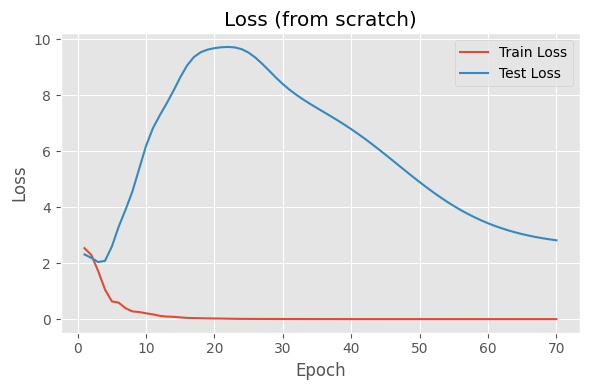

In [16]:
epoch_range = range(1, epochs + 1)
plt.figure(figsize=(6, 4))
plt.plot(epoch_range, train_loss1, label="Train Loss")
plt.plot(epoch_range, test_loss1, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss (from scratch)")
plt.legend()
plt.tight_layout()
plt.show()

## (2b) Train only last layer of pre-trained model

Create a new CNNModel, load pre-trained weights, fix the weights of all other layers and only train the last layer. 

Remember to implement what happens when **freeze_layers = True** in the given **train_model()** function.

- Here, we use a pretrained model by loading its weights with `model2.load_state_dict(torch.load("pretrained_MNIST_model.pt"))`. We freeze all layers except the last (fc1) by setting `freeze_layers` to `True`, so only the final layer is fine-tuned when we call `train_model()`.

In [18]:
# Transfer Learning: Freeze all but last layer
model2 = CNNModel()
model2.load_state_dict(torch.load("pretrained_MNIST_model.pt"))
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01)
epochs = 70
freeze_layers = True
train_loss2, test_loss2, train_acc2, test_acc2 = train_model(model2, train_loader, test_loader, optimizer2, 
                                                             criterion, epochs=epochs, freeze_layers=freeze_layers)

Epoch  1/70 | Train Loss: 10.3249 | Train Acc: 13.28% | Test Loss: 4.6077 | Test Acc: 22.53%
Epoch  2/70 | Train Loss: 6.0540 | Train Acc: 25.78% | Test Loss: 3.3054 | Test Acc: 29.61%
Epoch  3/70 | Train Loss: 3.7254 | Train Acc: 39.06% | Test Loss: 2.6625 | Test Acc: 38.05%
Epoch  4/70 | Train Loss: 2.4371 | Train Acc: 48.44% | Test Loss: 2.3402 | Test Acc: 44.78%
Epoch  5/70 | Train Loss: 1.7668 | Train Acc: 56.25% | Test Loss: 2.0748 | Test Acc: 50.14%
Epoch  6/70 | Train Loss: 1.1403 | Train Acc: 64.06% | Test Loss: 1.8857 | Test Acc: 56.47%
Epoch  7/70 | Train Loss: 0.7263 | Train Acc: 80.47% | Test Loss: 1.8122 | Test Acc: 59.25%
Epoch  8/70 | Train Loss: 0.4949 | Train Acc: 85.16% | Test Loss: 1.8067 | Test Acc: 60.20%
Epoch  9/70 | Train Loss: 0.3610 | Train Acc: 89.06% | Test Loss: 1.8307 | Test Acc: 61.05%
Epoch 10/70 | Train Loss: 0.2688 | Train Acc: 91.41% | Test Loss: 1.8787 | Test Acc: 62.08%
Epoch 11/70 | Train Loss: 0.2134 | Train Acc: 93.75% | Test Loss: 1.9418 | Test

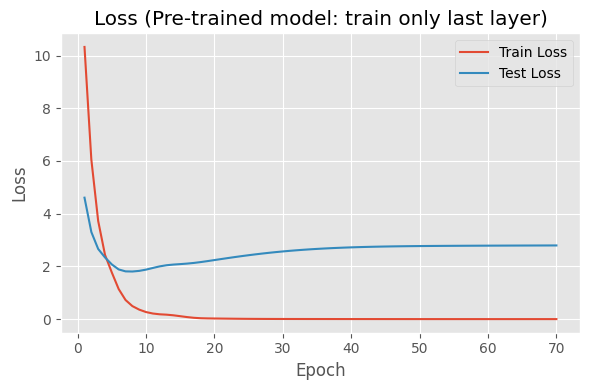

In [19]:
epoch_range = range(1, epochs + 1)
plt.figure(figsize=(6, 4))
plt.plot(epoch_range, train_loss2, label="Train Loss")
plt.plot(epoch_range, test_loss2, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss (Pre-trained model: train only last layer)")
plt.legend()
plt.tight_layout()
plt.show()

## (2c) Train all layers of pre-trained model

Create a new CNNModel, load pre-trained weights and fine-tune all weights.

- Here, we also start with a pretrained model using `model3.load_state_dict(torch.load("pretrained_MNIST_model.pt"))`, but we allow the whole network to be updated by setting `freeze_layers` to `False`, enabling full fine-tuning when `train_model()` is called.

In [20]:
model3 = CNNModel()
model3.load_state_dict(torch.load("pretrained_MNIST_model.pt"))
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.01)
epochs = 70
freeze_layers = False
train_loss3, test_loss3, train_acc3, test_acc3 = train_model(model3, train_loader, test_loader, optimizer3, 
                                                             criterion, epochs=epochs, freeze_layers=freeze_layers)

Epoch  1/70 | Train Loss: 10.3249 | Train Acc: 13.28% | Test Loss: 2.2430 | Test Acc: 29.70%
Epoch  2/70 | Train Loss: 2.5464 | Train Acc: 40.62% | Test Loss: 2.1010 | Test Acc: 42.66%
Epoch  3/70 | Train Loss: 1.1323 | Train Acc: 64.06% | Test Loss: 2.2624 | Test Acc: 45.03%
Epoch  4/70 | Train Loss: 0.7314 | Train Acc: 74.22% | Test Loss: 1.9307 | Test Acc: 57.68%
Epoch  5/70 | Train Loss: 0.3989 | Train Acc: 83.59% | Test Loss: 1.8112 | Test Acc: 61.76%
Epoch  6/70 | Train Loss: 0.3248 | Train Acc: 87.50% | Test Loss: 1.9029 | Test Acc: 58.87%
Epoch  7/70 | Train Loss: 0.2517 | Train Acc: 89.84% | Test Loss: 2.0201 | Test Acc: 59.11%
Epoch  8/70 | Train Loss: 0.2049 | Train Acc: 93.75% | Test Loss: 2.0425 | Test Acc: 62.29%
Epoch  9/70 | Train Loss: 0.1702 | Train Acc: 95.31% | Test Loss: 1.9814 | Test Acc: 63.44%
Epoch 10/70 | Train Loss: 0.1278 | Train Acc: 96.88% | Test Loss: 1.8811 | Test Acc: 64.94%
Epoch 11/70 | Train Loss: 0.0967 | Train Acc: 97.66% | Test Loss: 1.9258 | Test

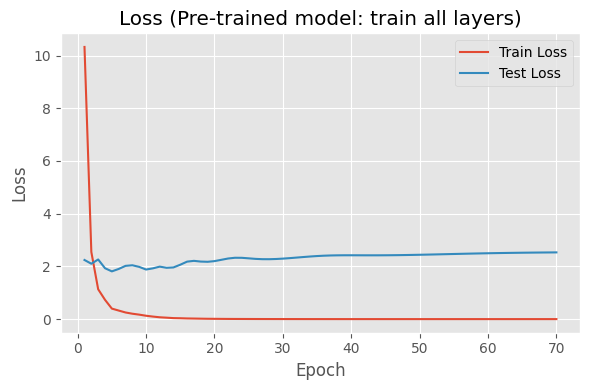

In [21]:
epoch_range = range(1, epochs + 1)
plt.figure(figsize=(6, 4))
plt.plot(epoch_range, train_loss3, label="Train Loss")
plt.plot(epoch_range, test_loss3, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss (Pre-trained model: train all layers)")
plt.legend()
plt.tight_layout()
plt.show()

## (2d) Plot and Report

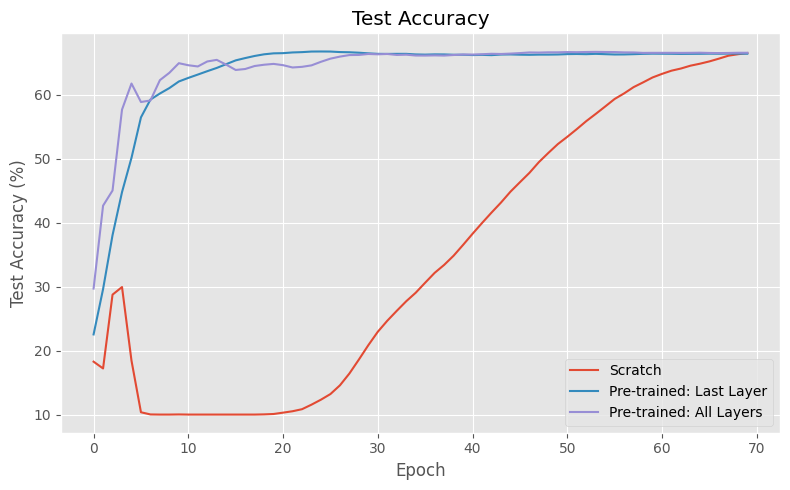

In [22]:
# Test Acc of all 3 methods
plt.figure(figsize=(8, 5))
plt.plot(test_acc1, label="Scratch")
plt.plot(test_acc2, label="Pre-trained: Last Layer")
plt.plot(test_acc3, label="Pre-trained: All Layers")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

### Observations

- All three variants reach fairly similar final accuracies with the training settings used here.

- Transfer learning significantly speeds up training. Model with pre-trained weights performs much better in the early epochs compared to one trained from scratch.

- There is no significant difference in final accuracy between fully fine-tuning the model and fine-tuning only the last layer, but training only the final layer is computationally faster. Note: However, the relative performance of these alternatives may depend on the specific problem and network architecture, so they might not be equally effective in all cases.

# 3. Few-shot learning

We use the trained classifier as a feature extractor. Specifically, some intermediate outputs of the neural networks are used as the features. Denote the feature extractor as $f$, then we can obtain the representation of one data point as $f(I)$. The method then performs nearest neighbor classification on the features, predicting the result as $y(x) = \arg\min_{c\in\{1,\dots,C\}}d(x,x_{c})$.

In principle, any set of neuron outputs within the network can be used as representation. In most cases, a layer close to the end of the network is chosen because it captures a rich set of learned features. In our case, two most natural options would be:

- The 576 dimensional feature vector we get by flattening the output from the final convolution layer.

- The 10 dimensional output layer (class probabilities).

Although both are technically possible, the 576 dimensional features are preferable here because they form a latent space that more generally encodes meaningful information about the image content. Final 10 neurons, are already tuned for classification on the source task, so they may lose some variability needed for the new task. In the code, `forward()` returns `features` by flattening the output of the last convolution block, and those features are what we use for few-shot learning.


In [23]:
from torch.utils.data import Dataset

# Set random seed for reproducibility -- DO NOT CHANGE THIS
seed = 42
random.seed(seed)
torch.manual_seed(seed)

# Define the model architecture
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Block 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(16)
        self.MaxPool1 = nn.MaxPool2d(kernel_size=2)

        # Block 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(32)
        self.MaxPool2 = nn.MaxPool2d(kernel_size=2)

        # Block 3
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(64)
        self.MaxPool3 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(576, 10)

    def forward(self, x):
        out = self.MaxPool1(self.bn1(self.relu1(self.cnn1(x))))
        out = self.MaxPool2(self.bn2(self.relu2(self.cnn2(out))))
        out = self.MaxPool3(self.bn3(self.relu3(self.cnn3(out))))

        features = out.view(out.size(0), -1)
        out = self.fc1(features)

        return out, features

class KShotCDataset(Dataset):
    def __init__(self, fashion_mnist_dataset, k_shot, c_way):
        self.fashion_mnist_dataset = fashion_mnist_dataset
        self.k_shot = k_shot
        self.c_way = c_way

        self.data_indices = []

        self.class_indices = {label: [] for label in range(self.c_way)}
        self.create_balanced_dataset()

    def create_balanced_dataset(self):
        for idx, (_, label) in enumerate(self.fashion_mnist_dataset):
            if label < self.c_way:
                self.class_indices[label].append(idx)

        for label in range(self.c_way):
            self.data_indices.extend(self.class_indices[label][:self.k_shot])

    def __len__(self):
        return len(self.data_indices)

    def __getitem__(self, index):
        fashion_mnist_index = self.data_indices[index]
        image, label = self.fashion_mnist_dataset[fashion_mnist_index]
        return image, label


def simple_shot(model, train_loader, test_loader, K):
    # Load K-shot data.
    features = []
    labels = []
    for i, (image, label) in enumerate(train_loader):
        _, output = model(image)
        features.append(output)
        labels.append(label)
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)

    # Get the centroids
    centroids = dict()
    for unique_label in torch.unique(labels):
        mask = labels == unique_label
        norm_feat = features[mask] / torch.norm(features[mask], dim=1).unsqueeze(1)
        centroids[unique_label] = norm_feat.mean(dim=0)

    # Get the cluster assignments based on l2-distance
    all_predicted = []
    all_labels = []
    for image, label in test_loader:
        _, output = model(image)
        output /= torch.norm(output, dim=1).unsqueeze(1)
        distances = torch.cdist(output, torch.stack(list(centroids.values())))
        _, predicted = torch.min(distances, dim=1)
        all_predicted.append(predicted)
        all_labels.append(label)

    # get accuracy
    all_predicted = torch.cat(all_predicted, dim=0)

    all_labels = torch.cat(all_labels, dim=0)
    accuracy = torch.mean((all_predicted == all_labels).float())*100
    return accuracy

transform = transforms.Compose([transforms.ToTensor()])

# Load the Fashion MNIST training dataset
fashionmnist_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

# ...and the test data as well
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True,
                                                 transform=transform)

C = 10  # Number of classes -- ordered labels are selected, e.g. C = 3 means labels=[0, 1, 2]
batch_size = 64

for K in [1, 7]:  # Number of shots per class
    # Create the K-shot C-way dataset
    k_shot_c_dataset = KShotCDataset(fashionmnist_dataset, K, C)

    # train data loader
    train_dataloader = DataLoader(k_shot_c_dataset, batch_size=K*C, shuffle=False)

    # test data loader
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = CNNModel()
    model.load_state_dict(torch.load('pretrained_MNIST_model.pt'))
    acc = simple_shot(model, train_dataloader, test_dataloader, K=K)
    print(f"Accuracy for {K} shot is {acc:.2f}")


Accuracy for 1 shot is 49.12
Accuracy for 7 shot is 69.09


### Observations

- We tested $K=1$ and $K=7$ for the few-shot classification. With $K=7$, we saw higher accuracy (about 69%) than with $K=1$ (about 49%), showing that having more examples per class significantly improves performance.

- In practice, $K$ can be viewed as a hyperparameter to be tuned. However, tuning requires access to labeled examples for the new task.

- The purpose of this exercise was to show how a neural network can act as feature extractor for other learning algorithms. Instead of relying on the standard linear classification layer, you can perform clustering, nearest neighbor classification, or other techniques directly on the extracted features. This can give good results, especially compared to using raw pixel data since network's latent space already encodes useful information about the images.